In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Union, Optional
from urllib.request import urlretrieve

pd.set_option("display.max_columns", None)
print("Setup Complete")

Setup Complete


### Fetch Data

In [3]:
# Fetch Data
url = "https://www.trade.gov/sites/default/files/2022-02/Monthly-Arrivals-2000-Present.xlsx"
file, _ = urlretrieve(url, filename="data/Monthly-Arrivals-2000-Present.xlsx")


### Function-load_and_tweak_countries

In [4]:
# Define a function to load the tweak for the countries df
def load_and_tweak_countries(file: str) -> pd.DataFrame:
    # Rename Headers
    rename_cols = {
        "International Visitors--\n   1) Country of Residence\n   2) 1+ nights in the USA\n   3)  Among qualified visa types": "Country",
        "World \nRegion": "World Region",
        "2023-02\nPreliminary": "2023-02",
        "2023-01\nPreliminary": "2023-01",
    }
    # Load Dataframe
    df = pd.read_excel(file, sheet_name="Monthly", usecols="A:C")

    # Tweak Dataframe
    df = (
        df.drop(columns=[1])
        .dropna(axis="index")
        .rename(columns=rename_cols)
        .reset_index(drop=True)
    )

    return df


df_countries = load_and_tweak_countries(file)
df_countries.head()

Monthly
Monthly Y-o-Y % Change


,Country,World Region
0,Afghanistan,Asia
1,Albania,Eastern Europe
2,Algeria,Africa
3,Andorra,Western Europe
4,Angola,Africa


In [5]:
df_countries.describe()


,Country,World Region
count,235,235
unique,235,10
top,Afghanistan,Africa
freq,1,57


In [6]:
df_countries.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       235 non-null    object
 1   World Region  235 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB


### Function-covert_to_datetime

In [7]:
# Define a function to change headers to datetime with specific date format
def convert_to_datetime(df: pd.DataFrame) -> pd.DatetimeIndex:
    df.columns = pd.to_datetime(df.columns).strftime("%Y-%m")
    df.columns = [pd.to_datetime(col) for col in df.columns]
    return df


# tweak_cols(df_travel)

### Function-load_and_tweak_travel

In [109]:
# Define a function to load the tweak for the travel df
def load_and_tweak_travel(file: str) -> pd.DataFrame:
    # Rename Headers
    rename_cols = {
        "International Visitors--\n   1) Country of Residence\n   2) 1+ nights in the USA\n   3)  Among qualified visa types": "Country",
        "World \nRegion": "World Region",
        "2023-02\nPreliminary": "2023-02",
        "2023-01\nPreliminary": "2023-01",
    }

    # Columns to drop
    cols_to_drop = [
        1,
        "Unnamed: 281",
        "Unnamed: 282",
        "Unnamed: 283",
        "Unnamed: 284",
        "Unnamed: 285",
        "Unnamed: 286",
        "Unnamed: 287",
        "Unnamed: 288",
        "Unnamed: 289",
        "Unnamed: 290",
        "Unnamed: 291",
        "Unnamed: 292",
        "Unnamed: 293",
        "Unnamed: 294",
        "Notes:",
        " ",
    ]
    # Load Dataframe
    df = pd.read_excel(file, sheet_name="Monthly")

    # Tweak Dataframe
    df = (
        df.rename(columns=rename_cols)
        .drop(columns=cols_to_drop)
        .dropna(axis="index", subset=["Country", "World Region"])
        .fillna(value=0)
        .set_index(["Country", "World Region"])
        .replace(
            {"-": 0, " ": 0, "   ": 0, "---": 0}, regex=True
        )  # Fill values with minus sign, one space, three spaces with 0
        .pipe(convert_to_datetime)  # Convert to datetime
        .astype(int)
    )

    return df


df_travel = load_and_tweak_travel(file)
df_travel

Monthly
Monthly Y-o-Y % Change


,,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,2003-06-01,2003-07-01,2003-08-01,2003-09-01,2003-10-01,2003-11-01,2003-12-01,2004-01-01,2004-02-01,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,2005-01-01,2005-02-01,2005-03-01,2005-04-01,2005-05-01,2005-06-01,2005-07-01,2005-08-01,2005-09-01,2005-10-01,2005-11-01,2005-12-01,2006-01-01,2006-02-01,2006-03-01,2006-04-01,2006-05-01,2006-06-01,2006-07-01,2006-08-01,2006-09-01,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
Country,World Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,3,10,7,8,15,9,11,20,19,14,3,10,16,8,6,8,4,16,13,31,7,4,3,9,1,4,2,11,18,30,7,17,7,16,9,13,16,10,8,28,20,31,11,28,16,25,19,15,20,9,22,27,26,50,29,33,25,23,10,30,29,27,63,31,34,69,88,71,71,76,50,62,37,43,47,64,43,51,79,99,41,62,47,65,63,30,53,34,48,78,85,101,70,48,49,58,44,26,47,53,54,88,0,0,61,66,40,69,48,66,87,73,80,126,140,180,84,111,57,86,92,46,83,57,68,163,134,134,118,113,114,139,134,107,129,141,125,209,164,190,184,145,129,143,108,72,95,107,125,126,124,195,132,67,124,134,74,93,112,85,91,236,131,238,164,162,248,193,162,145,156,254,214,247,230,354,210,235,165,360,162,132,192,181,214,153,269,347,261,294,286,465,313,20

In [9]:
df_travel.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 235 entries, ('Afghanistan', 'Asia') to ('Zimbabwe', 'Africa')
Columns: 278 entries, 2000-01-01 to 2023-02-01
dtypes: int64(278)
memory usage: 521.5+ KB


In [10]:
# Manual check if we have replaced correctly the target values
df_travel.query('Country=="Wallis And Futuna Islands"')


,,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,2003-06-01,2003-07-01,2003-08-01,2003-09-01,2003-10-01,2003-11-01,2003-12-01,2004-01-01,2004-02-01,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,2005-01-01,2005-02-01,2005-03-01,2005-04-01,2005-05-01,2005-06-01,2005-07-01,2005-08-01,2005-09-01,2005-10-01,2005-11-01,2005-12-01,2006-01-01,2006-02-01,2006-03-01,2006-04-01,2006-05-01,2006-06-01,2006-07-01,2006-08-01,2006-09-01,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
Country,World Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Wallis And Futuna Islands,Oceania,31,7,2,7,12,8,5,3,8,8,1,18,27,12,3,4,12,8,9,14,3,1,2,6,7,2,1,2,6,1,6,1,1,0,0,4,5,1,0,1,3,3,2,6,2,0,0,3,1,2,2,1,1,2,0,22,2,3,3,2,12,3,1,0,2,5,20,8,3,0,2,23,5,1,1,1,1,0,0,5,2,2,1,19,7,5,3,3,0,1,2,7,4,0,1,10,18,8,0,4,6,2,0,0,2,3,2,15,7,1,1,3,2,5,2,1,5,0,1,12,2,5,1,1,2,0,0,2,0,5,2,1,2,1,1,1,0,2,0,1,1,1,2,0,2,2,4,1,4,3,4,1,0,13,19,12,6,6,2,3,5,8,15,5,8,4,5,9,6,9,3,3,1,3,5,2,2,6,1,3,11,3,4,3,2,5,2,7,2,3,2,2,1,2,6,7,4,3,5,2,2,2,3,4,2,0,3,3,1,3,2,8,3,3,2,4,1,25,33,23,20,32,42,35,36,33,31,46,12,8,5,6,0,7,4,5,3,7,3,2,7,11,0,0,0,1,1,1,1,1,2,2,2,2,2,0,1,1,0,0,0,0,0,1,0,0,2,2,2,4,4,5,5,4,4,2,6,5


### Q3- In the most recent report, which 10 countries had the greatest number of tourists enter the US?

In [11]:
# Q3- In the most recent report, which 10 countries had the greatest number of tourists enter the US?
# The latest report is February 2023
df_2023 = df_travel[[df_travel.columns[-1]]].nlargest(
    n=10, columns=[df_travel.columns[-1]]
)
df_2023

,,2023-02-01
Country,World Region,
United Kingdom,Western Europe,251750
South Korea,Asia,116425
France,Western Europe,114659
Brazil,South America,101447
Germany,Western Europe,90144
Japan,Asia,82225
India,Asia,80806
Argentina,South America,48524
Australia,Oceania,46891


### Q4- In the first report, which 10 countries had the greatest number of tourists enter the US?

In [12]:
# Q4- In the first report, which 10 countries had the greatest number of tourists enter the US?
# The first report is the first column,January 2000
df_2000 = df_travel[[df_travel.columns[0]]].nlargest(
    n=10, columns=[df_travel.columns[0]]
)
df_2000

,,2000-01-01
Country,World Region,
Canada,North America,937669
Japan,Asia,354266
United Kingdom,Western Europe,242422
Mexico,North America,234000
Germany,Western Europe,100632
Brazil,South America,69634
France,Western Europe,63624
Argentina,South America,54136
South Korea,Asia,53797


### Q5-Total the number of tourists from each region in the earliest report vs. the latest report. 
### (Yes, you could get this directly from the original Excel spreadsheet, but I want you to calculate this yourself!) Do we see any changes in the last two decades or so?

In [13]:
# Q5- Total the number of tourists from each region in the earliest report vs. the latest report.
# (Yes, you could get this directly from the original Excel spreadsheet,
# but I want you to calculate this yourself!) Do we see any changes in the last two decades or so?

# Create a copy
df_travel_ = df_travel.reset_index().copy()

# Get the earliest and latest report
latest_col = df_travel_.columns[-1]  # February 2023
earliet_col = df_travel_.columns[-1]  # Janaury 2000

# Group by Region
df_region = (
    df_travel_.groupby(by=["World Region"])[latest_col]
    .sum()
    .to_frame()
    .sort_values(by=[latest_col], ascending=False)
)

df_region


,2023-02-01
World Region,
Western Europe,738375
Asia,390502
South America,310990
Caribbean,81425
Central America,81314
Oceania,57842
Middle East,54056
Eastern Europe,53630
Africa,23049


In [14]:
df_travel_.columns[2]

Timestamp('2000-01-01 00:00:00')

In [15]:
# Q5A- Total the number of tourists from each region in the earliest report vs. the latest report.
# (Yes, you could get this directly from the original Excel spreadsheet,
# but I want you to calculate this yourself!) Do we see any changes in the last two decades or so?

# Create a copy
df_travel_ = df_travel.reset_index().copy()

# Get the earliest and latest report
latest_col = df_travel_.columns[-3]  # December 2022
earliest_col = df_travel_.columns[2]  # Janaury 2000

# Group by Region
df_region = (
    df_travel_.groupby(by=["World Region"])[[earliest_col, latest_col]]
    .sum()
    .sort_values(by=[earliest_col, latest_col], ascending=False)
)

df_region


,2000-01-01 00:00:00,2022-12-01 00:00:00
World Region,,
North America,1171669,2533658
Western Europe,630045,945621
Asia,532666,482429
South America,240226,437318
Caribbean,73336,170148
Central America,64922,150045
Middle East,53081,76450
Oceania,51436,108771
Eastern Europe,29311,64752


<Figure size 500x1000 with 0 Axes>

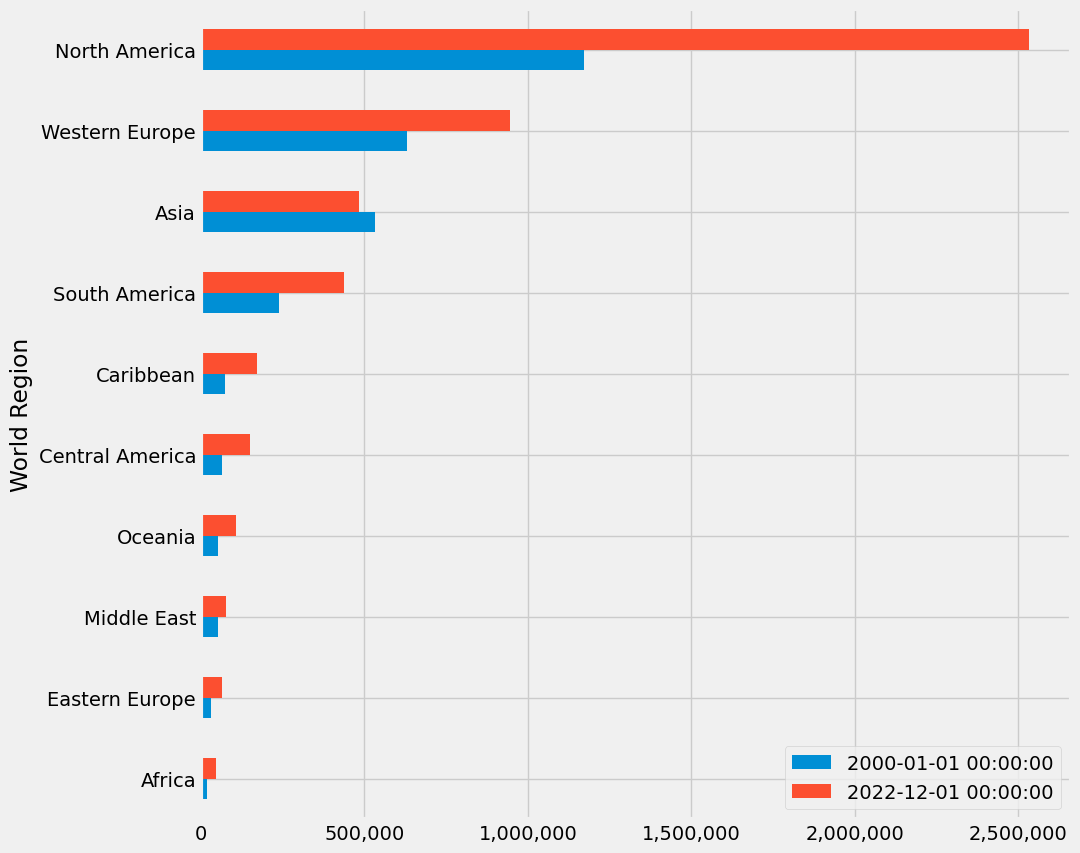

In [17]:
# Plot this in bar graph
# Style
plt.style.use("fivethirtyeight")
plt.figure(figsize=(5, 10))
# Sort values
df_region = df_region.sort_values(by=[df_region.columns[1]], ascending=True)
# Plot
ax = df_region.plot(kind="barh", figsize=(10, 10))

# Format
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.show()


#### Function-line_plot()

In [79]:
def line_plot(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: str,
    color_map: Optional[Union[str, list, dict]] = None,
    year_interval: int=5,
):
    # Style
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots(figsize=(20, 5))

    # Plot
    ax = sns.lineplot(df, x=x, y=y, hue=hue, palette=color_map, alpha=0.9, legend=False)
    # Add the text--for each line, find the end, annotate it with a label, and
    # adjust the chart axes so that everything fits on.
    for line, name in zip(ax.lines, df[hue].unique()):
        y = line.get_ydata()[-1]  # NB: to use start value, set [-1] to [0] instead
        x = line.get_xdata()[-1]
        if not np.isfinite(y):
            y = next(reversed(line.get_ydata()[~line.get_ydata().mask]), float("nan"))
        if not np.isfinite(y) or not np.isfinite(x):
            continue
        text = ax.annotate(
            name,
            xy=(x, y),
            xytext=(2, -2),  # YOU CAN ADJUST THE LOC OF LABEL HERE
            color=line.get_color(),
            xycoords=(ax.get_xaxis_transform(), ax.get_yaxis_transform()),
            textcoords="offset points",
            fontweight="regular",
        )
        text_width = (
            text.get_window_extent(fig.canvas.get_renderer())
            .transformed(ax.transData.inverted())
            .width
        )
        if np.isfinite(text_width):
            ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)

    # Format x-axis to view dates properly
    ax.xaxis.set_major_locator(mdates.YearLocator(base=year_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

    # Show plot
    plt.show()
    return

/var/folders/h2/6110hgtx6b7400ybw7yjhn400000gn/T/ipykernel_12552/3253194621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_region_all = (df_travel_.groupby(by=["World Region"]).sum())


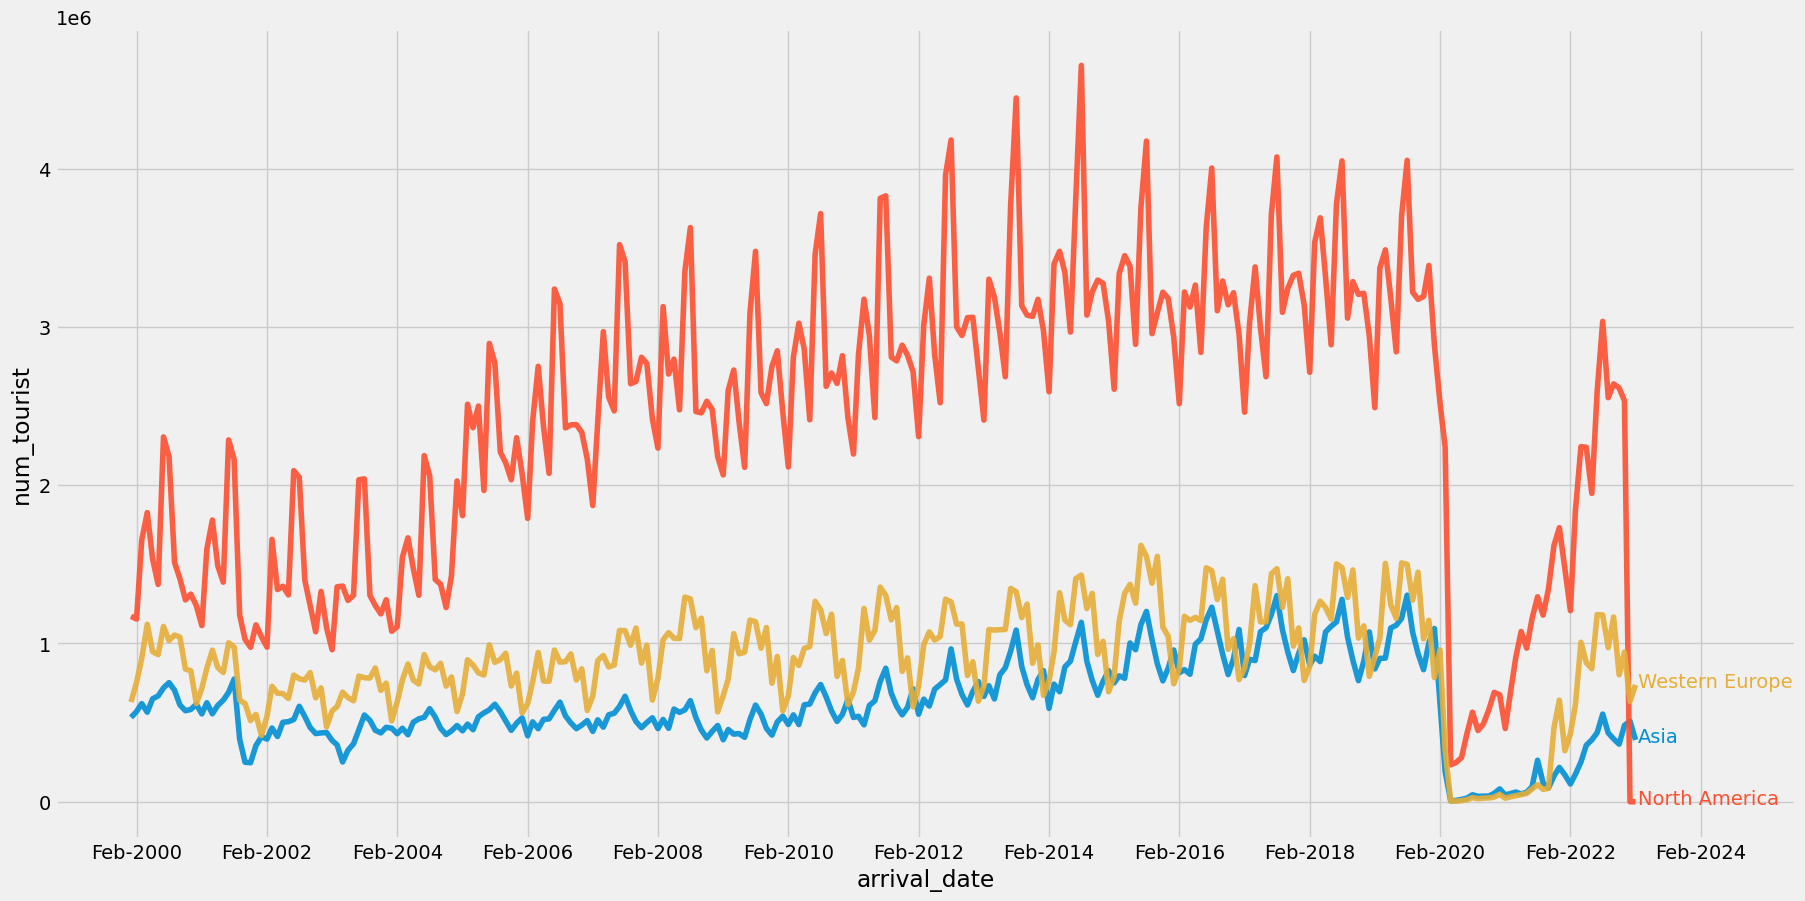

In [20]:
# Plot per Region

# Group by Region
df_region_all = df_travel_.groupby(by=["World Region"]).sum()
df_region_all


# Pivot
def tweak_(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = ["arrival_date", "region", "num_tourist"]
    return df


# Pivot
df_region_pivot = df_region_all.unstack().reset_index().pipe(tweak_)

df_region_pivot_ = df_region_pivot.loc[
    df_region_pivot["region"].isin(["Western Europe", "Asia", "North America"])
]

line_plot(
    df=df_region_pivot_,
    x="arrival_date",
    y="num_tourist",
    hue="region",
    month_interval=24,
)

In [21]:
# Manual check if we have replaced correctly the target values
df_travel.query('Country=="Wallis And Futuna Islands"')


,,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,2003-06-01,2003-07-01,2003-08-01,2003-09-01,2003-10-01,2003-11-01,2003-12-01,2004-01-01,2004-02-01,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,2005-01-01,2005-02-01,2005-03-01,2005-04-01,2005-05-01,2005-06-01,2005-07-01,2005-08-01,2005-09-01,2005-10-01,2005-11-01,2005-12-01,2006-01-01,2006-02-01,2006-03-01,2006-04-01,2006-05-01,2006-06-01,2006-07-01,2006-08-01,2006-09-01,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
Country,World Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Wallis And Futuna Islands,Oceania,31,7,2,7,12,8,5,3,8,8,1,18,27,12,3,4,12,8,9,14,3,1,2,6,7,2,1,2,6,1,6,1,1,0,0,4,5,1,0,1,3,3,2,6,2,0,0,3,1,2,2,1,1,2,0,22,2,3,3,2,12,3,1,0,2,5,20,8,3,0,2,23,5,1,1,1,1,0,0,5,2,2,1,19,7,5,3,3,0,1,2,7,4,0,1,10,18,8,0,4,6,2,0,0,2,3,2,15,7,1,1,3,2,5,2,1,5,0,1,12,2,5,1,1,2,0,0,2,0,5,2,1,2,1,1,1,0,2,0,1,1,1,2,0,2,2,4,1,4,3,4,1,0,13,19,12,6,6,2,3,5,8,15,5,8,4,5,9,6,9,3,3,1,3,5,2,2,6,1,3,11,3,4,3,2,5,2,7,2,3,2,2,1,2,6,7,4,3,5,2,2,2,3,4,2,0,3,3,1,3,2,8,3,3,2,4,1,25,33,23,20,32,42,35,36,33,31,46,12,8,5,6,0,7,4,5,3,7,3,2,7,11,0,0,0,1,1,1,1,1,2,2,2,2,2,0,1,1,0,0,0,0,0,1,0,0,2,2,2,4,4,5,5,4,4,2,6,5


### Q6- Have any countries had more month-to-month declines in tourism to the US than increases?

In [121]:
# Define a function to load the tweak for the travel df
def load_and_tweak_travel_(file: str) -> pd.DataFrame:
    # Rename Headers
    rename_cols = {
        "International Visitors--\n   1) Country of Residence\n   2) 1+ nights in the USA\n   3)  Among qualified visa types": "Country",
        "World \nRegion": "World Region",
        "2023-02\nPreliminary": "2023-02",
        "2023-01\nPreliminary": "2023-01",
    }

    # Columns to drop
    cols_to_drop = [
        1,
        "Unnamed: 281",
        "Unnamed: 282",
        "Unnamed: 283",
        "Unnamed: 284",
        "Unnamed: 285",
        "Unnamed: 286",
        "Unnamed: 287",
        "Unnamed: 288",
        "Unnamed: 289",
        "Unnamed: 290",
        "Unnamed: 291",
        "Notes:",
        " ",
    ]
    # Load Dataframe
    df = pd.read_excel(file, sheet_name="Monthly Y-o-Y % Change")

    # Tweak Dataframe
    df = (
        df.rename(columns=rename_cols)
        .drop(columns=cols_to_drop)
        .dropna(axis="index", subset=["Country", "World Region"])
        .fillna(value=0)
        .set_index(["Country", "World Region"])
        .replace(
            {"-": 0, " ": 0, "   ": 0, "---": 0}, regex=True
        )  # Fill values with minus sign, one space, three spaces with 0
        .pipe(convert_to_datetime)  # Convert to datetime
        .astype(float)
        .multiply(100)
    )

    return df



In [130]:
# Q6A- Have any countries had more month-to-month declines in tourism to the US than increases?
# One way to solve this is to count the negative and positive percentage per country. 
# then get the variance, if its negative then the country had more declines in tourism

# using the Monthly Y-o-Y % Change
df_travel_yoy = load_and_tweak_travel_(file)
df_travel_yoy.head()

Monthly
Monthly Y-o-Y % Change


,,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,2003-06-01,2003-07-01,2003-08-01,2003-09-01,2003-10-01,2003-11-01,2003-12-01,2004-01-01,2004-02-01,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,2005-01-01,2005-02-01,2005-03-01,2005-04-01,2005-05-01,2005-06-01,2005-07-01,2005-08-01,2005-09-01,2005-10-01,2005-11-01,2005-12-01,2006-01-01,2006-02-01,2006-03-01,2006-04-01,2006-05-01,2006-06-01,2006-07-01,2006-08-01,2006-09-01,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
Country,World Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,433.333333,-20.000000,-14.285714,0.000000,-73.333333,77.777778,18.181818,55.000000,-63.157895,-71.428571,0.000000,-10.000000,-93.750000,-50.000000,-66.666667,37.500000,350.000000,87.500000,-46.153846,-45.161290,0.000000,300.000000,200.000000,44.444444,1500.000000,150.000000,300.000000,154.545455,11.111111,3.333333,57.142857,64.705882,128.571429,56.250000,111.111111,15.384615,25.000000,-10.000000,175.000000,-3.571429,30.000000,61.290323,163.636364,17.857143,56.250000,-8.000000,-47.368421,100.000000,45.000000,200.000000,186.363636,14.814815,30.769231,38.000000,203.448276,

In [131]:
df_travel_yoy[df_travel_yoy<1]

,,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,2001-06-01,2001-07-01,2001-08-01,2001-09-01,2001-10-01,2001-11-01,2001-12-01,2002-01-01,2002-02-01,2002-03-01,2002-04-01,2002-05-01,2002-06-01,2002-07-01,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,2003-04-01,2003-05-01,2003-06-01,2003-07-01,2003-08-01,2003-09-01,2003-10-01,2003-11-01,2003-12-01,2004-01-01,2004-02-01,2004-03-01,2004-04-01,2004-05-01,2004-06-01,2004-07-01,2004-08-01,2004-09-01,2004-10-01,2004-11-01,2004-12-01,2005-01-01,2005-02-01,2005-03-01,2005-04-01,2005-05-01,2005-06-01,2005-07-01,2005-08-01,2005-09-01,2005-10-01,2005-11-01,2005-12-01,2006-01-01,2006-02-01,2006-03-01,2006-04-01,2006-05-01,2006-06-01,2006-07-01,2006-08-01,2006-09-01,2006-10-01,2006-11-01,2006-12-01,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,2007-10-01,2007-11-01,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,2010-11-01,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
Country,World Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-20.000000,-14.285714,0.000000,-73.333333,NaN,NaN,NaN,-63.157895,-71.428571,0.000000,-10.000000,-93.750000,-50.000000,-66.666667,NaN,NaN,NaN,-46.153846,-45.161290,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.000000,NaN,-3.571429,NaN,NaN,NaN,NaN,NaN,-8.000000,-47.368421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.396825,NaN,NaN,-26.086957,-10.227273,NaN,-42.253521,-18.421053,-6.000000,NaN,NaN,-30.232558,NaN,-46.875000,NaN,NaN,NaN,NaN,NaN,-22.580645,NaN,-10.769231,-30.158730,-13.333333,-11.320755,NaN,NaN,NaN,0.000000

In [147]:
# Count
df_travel_yoy = df_travel_yoy.assign(
    negative=df_travel_yoy[df_travel_yoy < 0].count(axis="columns"),
    positive=df_travel_yoy[df_travel_yoy > 0].count(axis="columns"),
)
df_travel_yoy = df_travel_yoy.assign(variance=df_travel_yoy["positive"] - df_travel_yoy["negative"])
df_var = df_travel_yoy[["positive","negative", "variance"]]

df_var.head()

,,positive,negative,variance
Country,World Region,,,
Afghanistan,Asia,173,86,87
Albania,Eastern Europe,167,101,66
Algeria,Africa,177,91,86
Andorra,Western Europe,147,117,30
Angola,Africa,156,113,43


In [146]:
num_negative = df_var["variance"][df_var["variance"] < 0].count()
perc_negative = num_negative / df_travel_yoy.shape[0]
print(f"The percentage of countries that shows decline in tourism to the US from 2002 to 2022 is {perc_negative:.2%}")

The percentage of countries that shows decline in tourism to the US from 2002 to 2022 is 5.96%


In [154]:
# Which countries shows decline?
df_var[df_var["variance"] < 0][["variance"]]

,,variance
Country,World Region,
Dominica,Caribbean,-6
Falkland Islands,South America,-3
Guinea,Africa,-18
Kiribati,Oceania,-27
Laos,Asia,-10
Liberia,Africa,-14
Martinique,Caribbean,-1
Netherlands Antilles,Caribbean,-42
Papua New Guinea,Oceania,-6


In [22]:
# Q6A- Have any countries had more month-to-month declines in tourism to the US than increases?
# using the graph above, it seems Asia shows decline in tourist arrival to the US (2000 to 2022)
df_asia = (
    df_travel_.query('`World Region`== "Asia"')
    .drop(columns=["World Region"])
    .set_index("Country")
)
df_asia

,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01 00:00:00,2012-12-01 00:00:00,2013-01-01 00:00:00,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-04-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,2013-11-01 00:00:00,2013-12-01 00:00:00,2014-01-01 00:00:00,2014-02-01 00:00:00,2014-03-01 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00

In [23]:
# Pivot
def tweak(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = ["arrival_date", "country", "num_tourist"]
    return df

# Pivot
df_asia_pivot = df_asia.unstack().reset_index().pipe(tweak)

df_asia_pivot

,arrival_date,country,num_tourist
0,2000-01-01,Afghanistan,3
1,2000-01-01,Bangladesh,854
2,2000-01-01,Bhutan,23
3,2000-01-01,Brunei,76
4,2000-01-01,Burma (Myanmar),107
...,...,...,...
9447,2023-02-01,Tajikistan,122
9448,2023-02-01,Thailand,3002
9449,2023-02-01,Turkmenistan,116
9450,2023-02-01,Uzbekistan,588


#### Plot - df_asia_pivot

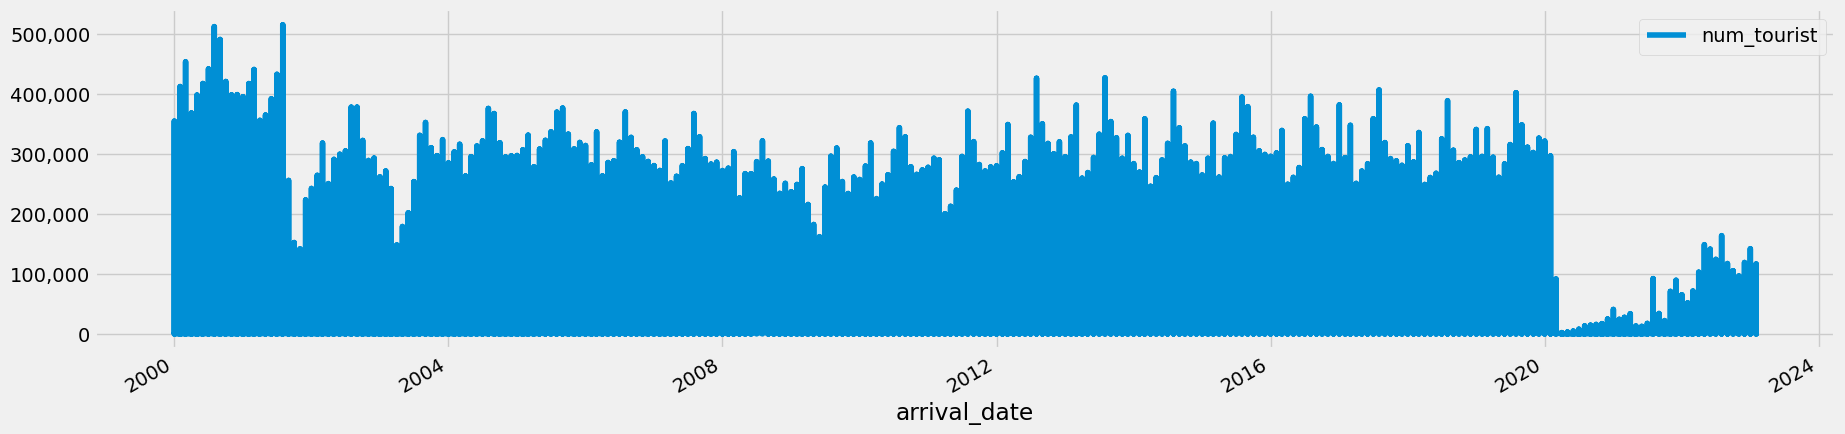

In [24]:
# Plot
ax = df_asia_pivot.plot(kind="line", x="arrival_date", y="num_tourist", figsize=(20, 5))

# Format
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

#### Plot - df_asia_pivot hue by country

<Figure size 2000x500 with 0 Axes>

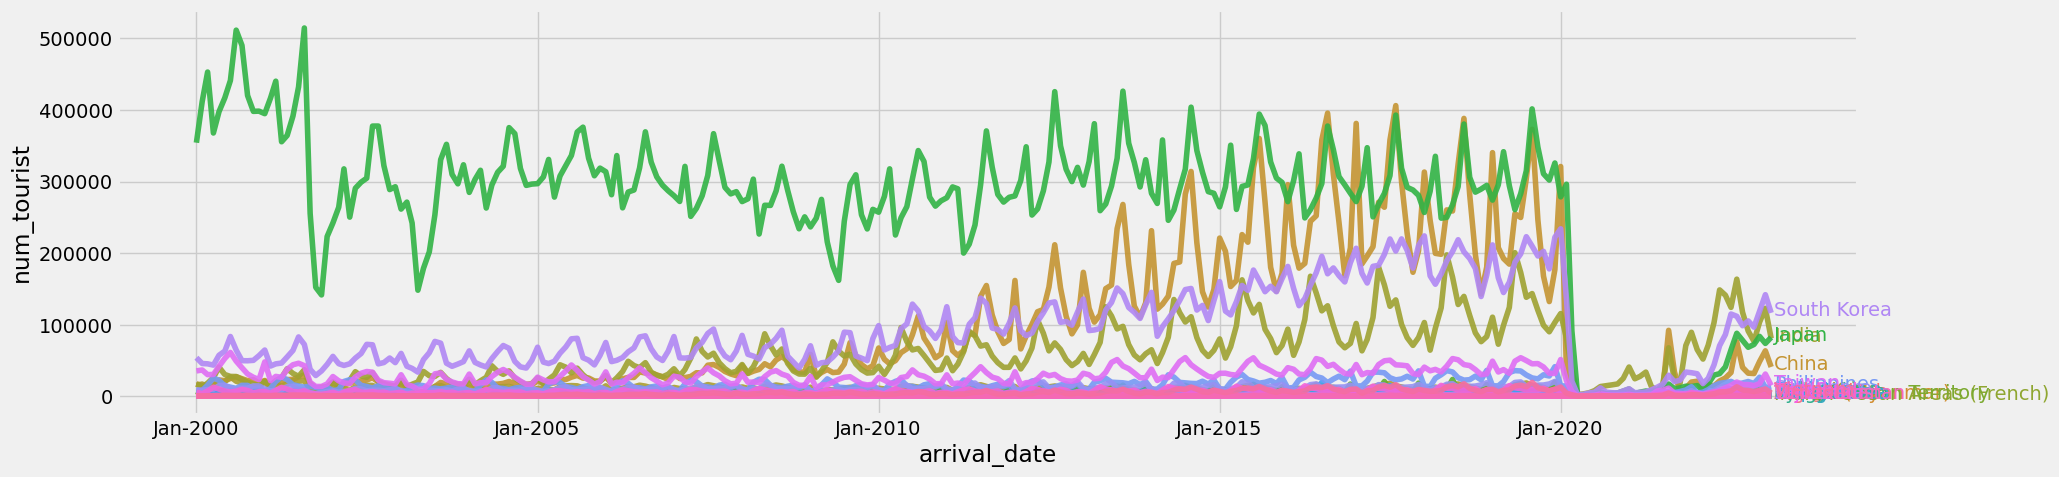

In [80]:
# Using seaborn
# Style
plt.figure(figsize=(20, 5))

# Plot

# ax = sns.lineplot(data=df_asia_pivot, x="arrival_date", y="num_tourist", hue="country")

# Plot
line_plot(
    df=df_asia_pivot,
    x="arrival_date",
    y="num_tourist",
    hue="country",
    year_interval=5,
)

#### Plot - df_asia_pivot filtered country

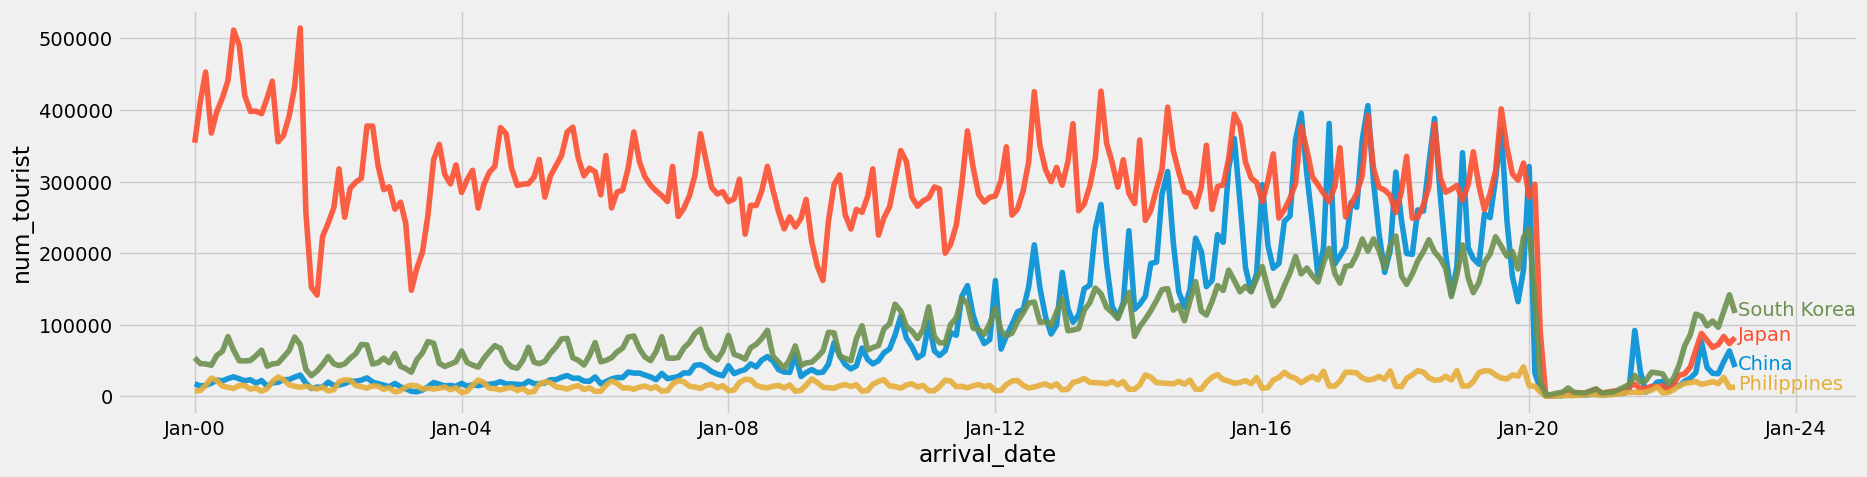

In [78]:
# Filtered Country
df_asia_pivot_filtered = df_asia_pivot[
    df_asia_pivot["country"].isin(["Japan", "South Korea", "China", "Philippines"])
]
df_asia_pivot_filtered
# Plot
line_plot(
    df=df_asia_pivot_filtered,
    x="arrival_date",
    y="num_tourist",
    hue="country",
    year_interval=4,
)

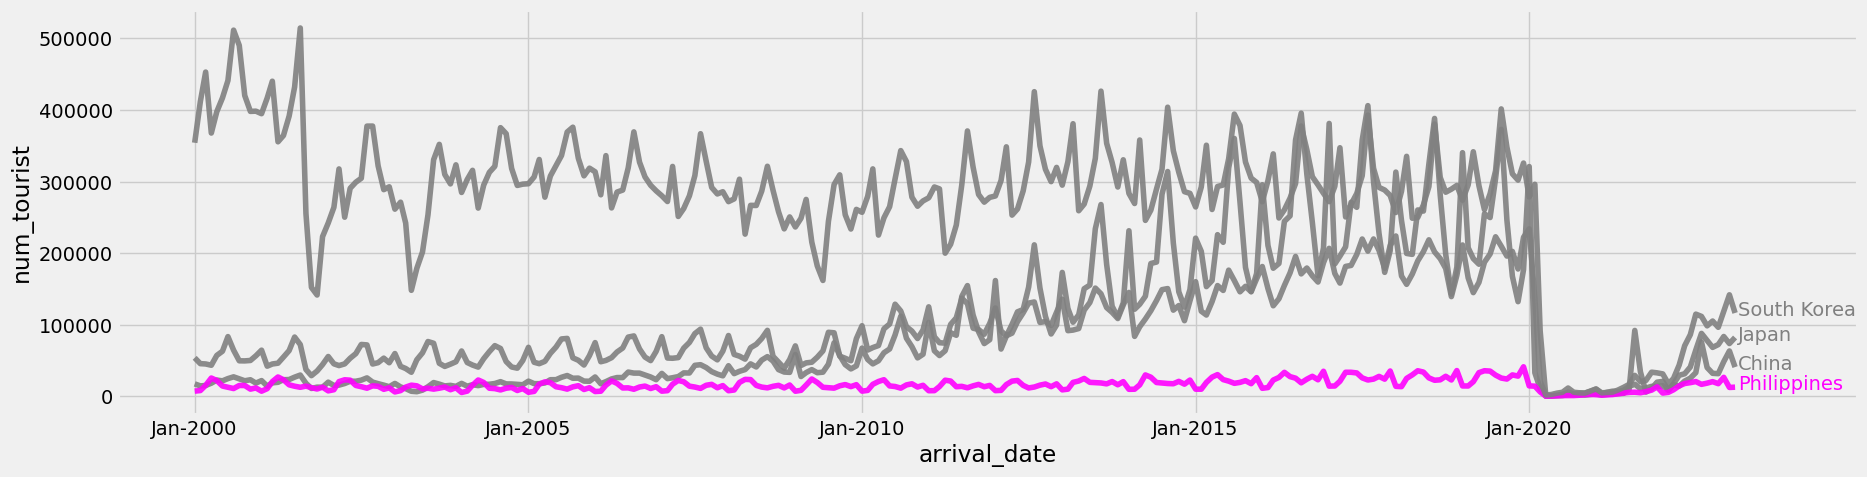

In [85]:
# Filtered Country
df_asia_pivot_filtered = df_asia_pivot[
    df_asia_pivot["country"].isin(["Japan", "South Korea", "China", "Philippines"])
]
df_asia_pivot_filtered
# Color Palette
grey_palette = {"Japan": "gray", "South Korea":"gray", "China":"gray", "Philippines":"magenta"}

# Plot
line_plot(
    df=df_asia_pivot_filtered,
    x="arrival_date",
    y="num_tourist",
    hue="country",
    year_interval=5,
    color_map=grey_palette
)

### Calculate the mean of tourists from each country for each decade. (And yes, the current decade will be listed as December 31st, 2030.)

In [27]:
df_travel_.head(n=2)


,Country,World Region,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01 00:00:00,2012-12-01 00:00:00,2013-01-01 00:00:00,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-04-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,2013-11-01 00:00:00,2013-12-01 00:00:00,2014-01-01 00:00:00,2014-02-01 00:00:00,2014-03-01 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-01 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:0

### Q7- Calculate the mean of tourists from each country for each decade. (And yes, the current decade will be listed as December 31st, 2030.)


In [50]:
# Q7- Calculate the mean of tourists from each country for each decade. (And yes, the current decade will be listed as December 31st, 2030.)

# # Group by country
# df_region_all = (df_travel_.groupby(by=["World Region"]).sum())
# df_region_all


# Pivot
def tweak_(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = ["arrival_date", "country", "avg_num_tourist"]
    return df


# Pivot
df_country_pivot = (
    df_travel_.drop(columns=["World Region"])
    .set_index("Country")
    .unstack()
    .reset_index()
    .pipe(tweak_)
)

df_country_pivot.head()
# Groupby country then by arrival_date with 10 year frequency
df_10y = (
    df_country_pivot.groupby(
        by=["country", pd.Grouper(key="arrival_date", freq="10Y")]
    )[["avg_num_tourist"]]
    .mean()
    .reset_index()
)

df_10y


,country,arrival_date,avg_num_tourist
0,Afghanistan,2000-12-31,10.750000
1,Afghanistan,2010-12-31,48.366667
2,Afghanistan,2020-12-31,185.041667
3,Afghanistan,2030-12-31,175.230769
4,Albania,2000-12-31,478.083333
...,...,...,...
935,Zambia,2030-12-31,223.076923
936,Zimbabwe,2000-12-31,673.333333
937,Zimbabwe,2010-12-31,406.450000
938,Zimbabwe,2020-12-31,514.525000


In [29]:
df_10y.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   country          940 non-null    object        
 1   arrival_date     940 non-null    datetime64[ns]
 2   avg_num_tourist  940 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 22.2+ KB


#### Plot df_ph

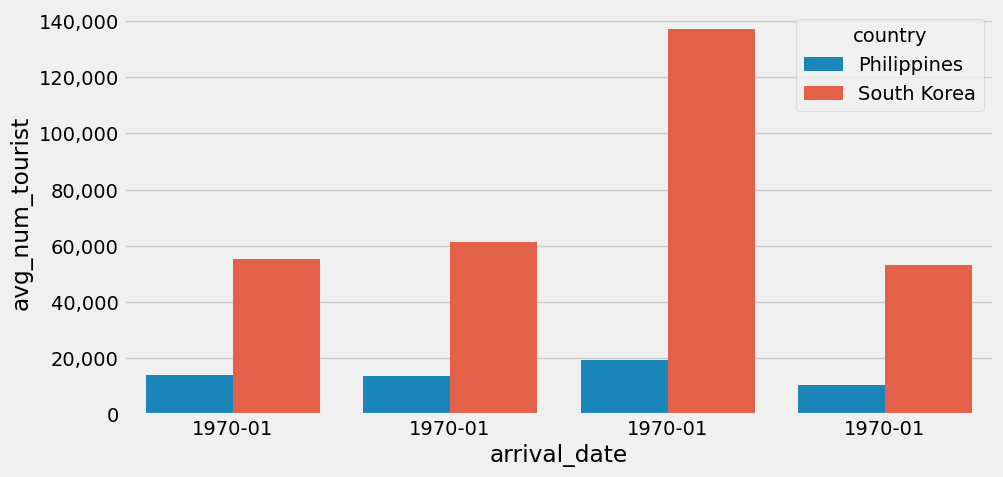

In [54]:

# Filter df
df_ph = df_10y.loc[df_10y["country"].isin(["Philippines", "South Korea"])]
# Convert "arrival_date" column to datetime object
# Style
fig, ax = plt.subplots(figsize=(10, 5))

# using Seaborn
ax = sns.barplot(data=df_ph, x="arrival_date", y="avg_num_tourist", hue="country")

# using pandas built in plot
# ax = df_ph.plot(kind="bar", x="arrival_date", y="avg_num_tourist", figsize=(5,5))

# Format x-axis to view dates properly and y-axis to view values with thousands
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))


plt.show()